<a href="https://colab.research.google.com/github/arokem/IntroDL/blob/master/OHBMdemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget -nc https://storage.googleapis.com/ohbm-dl-lindsay-data/trunc_data.pkl

File ‘trunc_data.pkl’ already there; not retrieving.



In [0]:
!wget -nc https://raw.githubusercontent.com/arokem/2019-OHBM-DL-educourse-Lindsay/master/mnistData.py 

File ‘mnistData.py’ already there; not retrieving.



In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import mnistData as mnist


np.random.seed(234)

batch_size = 128 #number of training images for each batch
im_size = 28 #the images are 28 x 28 pixels
num_classes = 10 #there are 10 digit classes

data = mnist.DataObject(batch_size) #how we will interface with the data



In [0]:

#These functions create weight and bias variables for the layers
def weight_variable(shape, vname):
        initial = tf.truncated_normal(shape, stddev=0.05)
        return tf.Variable(initial, name=vname)

def bias_variable(shape, vname):
        initial = tf.constant(0.0, shape=shape)
        return tf.Variable(initial, name=vname)
    
#This makes the scaling factors for attention the right size
def attn_input(vals, shape):
    if len(shape)==4:
        evals = tf.expand_dims(tf.expand_dims(tf.expand_dims(vals,0),0),0)
    else:
        evals = tf.expand_dims(vals,0)

    shape[-1] = 1
    return tf.tile(evals,shape)

    
#The following functions create the different kinds of layers that will make up the network.
#In tensorflow, networks are represented as graphs, with nodes representing different computations.
def conv_layer(conv_input, filt_shape, TCs, conv_num):
          '''This function adds a convolutional layer to the graph. Also include the rectified linear nonlinearity
          conv_input - the output of the previous layer, or in the case of the first conv layer, the image itself
          filt_shape - given in the from [x,y,inp_filt,out_filt] where x and y are the spatial dimensions of the filters to be applied...
           inp_filt is the depth of the input tensor and out_filt is the number of filters to be applied
          conv_num - integer x, for the x-th convolution in the network 
          '''
          W_conv = weight_variable(filt_shape,'conv_w'+str(conv_num))
          b_conv = bias_variable([filt_shape[-1]],'conv_b'+str(conv_num)) 
          h_conv = tf.nn.relu(tf.nn.conv2d(conv_input, W_conv, strides=[1, 1, 1, 1], padding='SAME') + b_conv,'conv'+str(conv_num))
          out_shape = h_conv.get_shape().as_list()
          attn = attn_input(TCs,out_shape)
          return tf.multiply(h_conv, attn) 
    
def pooling_layer(pool_input, ksize, pool_num):
          '''This function adds a max-pooling layer to the graph
          pool_input - the output of the previous layer
          ksize - given in form [1,x,y,1] where x and y are the height and width of the kernel size for the pooling (the area to take the max over)
          pool_num - integer x, for the x-th pooling layer in the network 
          '''
          h_pool = tf.nn.max_pool(pool_input, ksize=ksize, strides=[1, 2, 2, 1], padding='SAME',name='pool'+str(pool_num))
          return h_pool

def fullyconnected_layer(fc_input, inp_units, out_size, TCs, fc_num):
          '''This function adds a fully-connected layer to the graph
          fc_input - the output of the previous layer
          out_size - number of units in the fully connected layer
          fc_num - integer x, for the x-th fully connected layer in the network 
          '''
          inp_shape = tf.shape(fc_input);
          inp_dimens = tf.shape(inp_shape);

          W_fc = weight_variable([inp_units, out_size],'fc_w'+str(fc_num))
          b_fc = bias_variable([out_size],'fc_b'+str(fc_num))

          inp_flat = tf.reshape(fc_input, [batch_size, -1])
          h_fc = tf.nn.relu(tf.matmul(inp_flat, W_fc) + b_fc,'fc'+str(fc_num))
          out_shape = h_fc.get_shape().as_list()

          attn = attn_input(TCs,out_shape)
          h_fc_attn = tf.multiply(h_fc,attn)
          h_fc_drop = tf.nn.dropout(h_fc_attn, keep_prob)
        
          return h_fc_drop
        
def readout_layer(ro_input,inp_units, out_size):
          '''This function adds a fully-connected layer to the graph that should be the final layer
          ro_input - the output of the previous layer
          out_size - number of units, should be equal to number of classes
          '''
          inp_shape = tf.shape(ro_input);
          inp_dimens = tf.shape(inp_shape);

          W_fc = weight_variable([inp_units, out_size],'ro_w')
          b_fc = bias_variable([out_size],'ro_b')

          inp_flat = tf.reshape(ro_input, [batch_size, -1])
          h_fc = tf.nn.relu(tf.matmul(inp_flat, W_fc) + b_fc,'ro')
          return h_fc
          


#In tensorflow, inputs are given as placeholders. This takes the place of the actual images that will be used when we run the network later.
x = tf.placeholder(tf.float32, [batch_size, im_size**2])
x_image = tf.reshape(x, [-1,im_size,im_size,1])
keep_prob = tf.placeholder(tf.float32) #for adding dropout



y_int = tf.placeholder(tf.int32, [batch_size]) # this is the placeholder for the output---that is, the digit label for each image 
y_ = tf.one_hot(y_int, num_classes)




In [0]:

#BUILD A CONVOLUTIONAL NEURAL NETWORK:
FM_1 = 32 #number of features at each layer
FM_2 = 64
FM_3 = 1024

#These will be filled with digit-specific attention values:
TVals_1 = tf.placeholder(tf.float32,[FM_1])
TVals_2 = tf.placeholder(tf.float32,[FM_2])
TVals_3 = tf.placeholder(tf.float32,[FM_3])

#Building the network:
conv_1 = conv_layer(x_image,[3,3,1,FM_1],TVals_1,1)
pool_1 = pooling_layer(conv_1,[1,3,3,1],1)
conv_2 = conv_layer(pool_1,[3,3,FM_1,FM_2],TVals_2,2)
pool_2 = pooling_layer(conv_2,[1,3,3,1],2)
flatten_units = np.prod(pool_2.get_shape().as_list()[1:])
fc_1 = fullyconnected_layer(pool_2,flatten_units,FM_3,TVals_3,1)
readout = readout_layer(fc_1,FM_3,num_classes)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



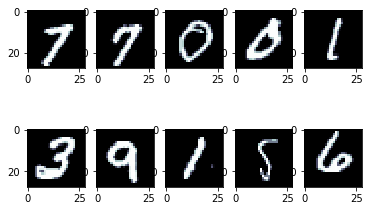

In [0]:
#Comparing the activity of the final layer with the true digit label using cross entropy loss: 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = readout, labels = y_))


#Using the ADAM optimizer that implements a modified backpropagataion 
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy) 

#Calculating how many images were classified correctly:
preds = tf.argmax(readout,1)
correct_prediction = tf.equal(preds, tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#What the images look like:
plt.figure()
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(np.reshape(data.val_images[i,:],[im_size,im_size]),cmap='bone')


Batch 0
Batch 50
Batch 100
Batch 150
Batch 200
Batch 250


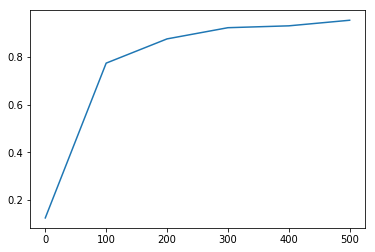

In [0]:
#The tensorflow graph is now built. The next thing to do is start a tensorflow session and start training the model.

#Train the model
#Start TF session and initialize variables
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

val_acc = 0.; val_curve = []; #we will keep track of the validation set accuracy
cur_batch = -1 #this is the current batch number we are on

#getting the validation set
ims_val = data.val_images[0:batch_size,:]
labs_val = data.val_labels[0:batch_size]


#training loop:
#(the attention values are all set to 1 during training)
while (val_acc < .95 and cur_batch < 3000): #stop training when we get 95% validation accuracy or get to 3000 batches
    
    cur_batch+=1
    ims, labs = data.get_trainbatch() #get a training batch to pass into the network
    
    train_step.run(feed_dict={x: ims, y_int: labs, TVals_1: np.ones(FM_1), TVals_2: np.ones(FM_2), TVals_3: np.ones(FM_3), keep_prob: .5}) #this is how we pass the real images and labels to the placeholders and run a training step
    
    if cur_batch%50 == 0: #Every 50 batches, print the validation accuracy
        print('Batch ' + str(cur_batch))
    
        #CALCULATE THE VALIDATION ACCURACY:
        val_acc = accuracy.eval(feed_dict={x: ims_val, y_int: labs_val, TVals_1: np.ones(FM_1), TVals_2: np.ones(FM_2),TVals_3: np.ones(FM_3), keep_prob: 1.})
        val_curve.append(val_acc)
    


#PLOT THE VALIDATION ACCURACY AS A FUNCTION OF TRAINING BATCH:
plt.plot(np.arange(len(val_curve))*100,val_curve)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


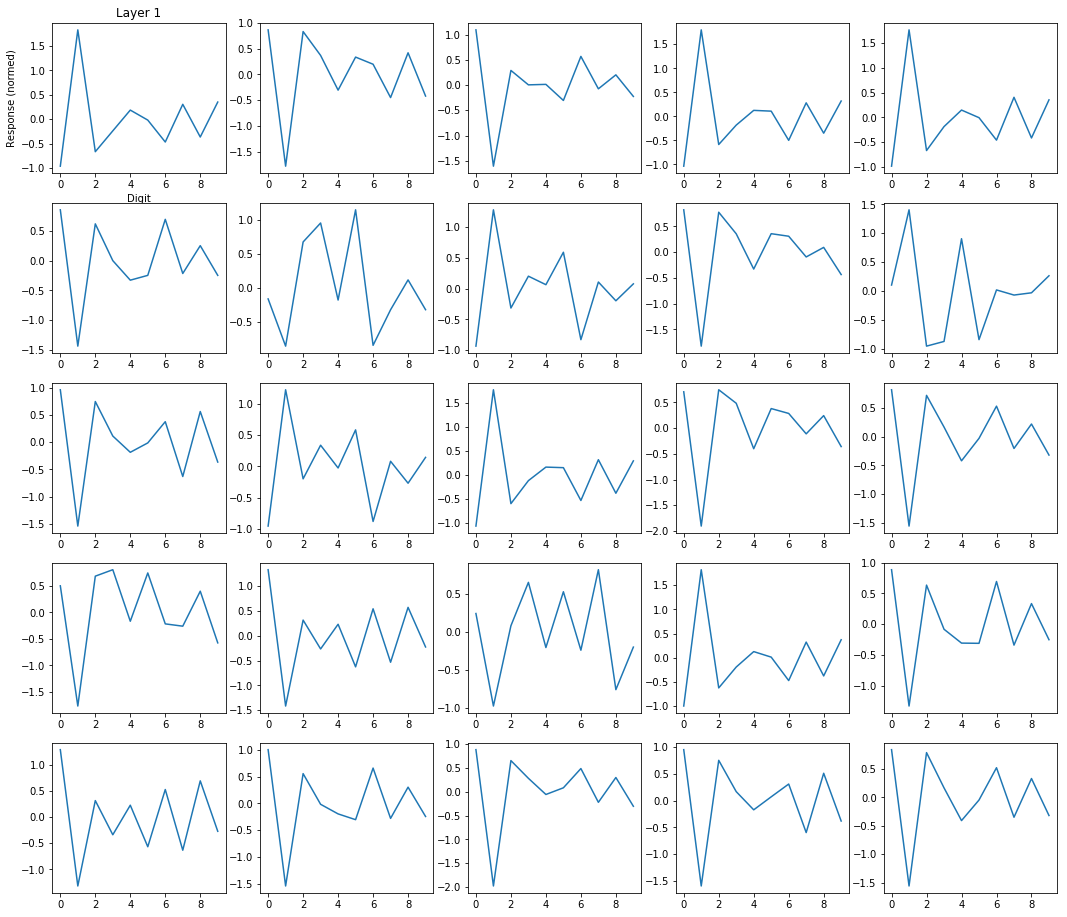

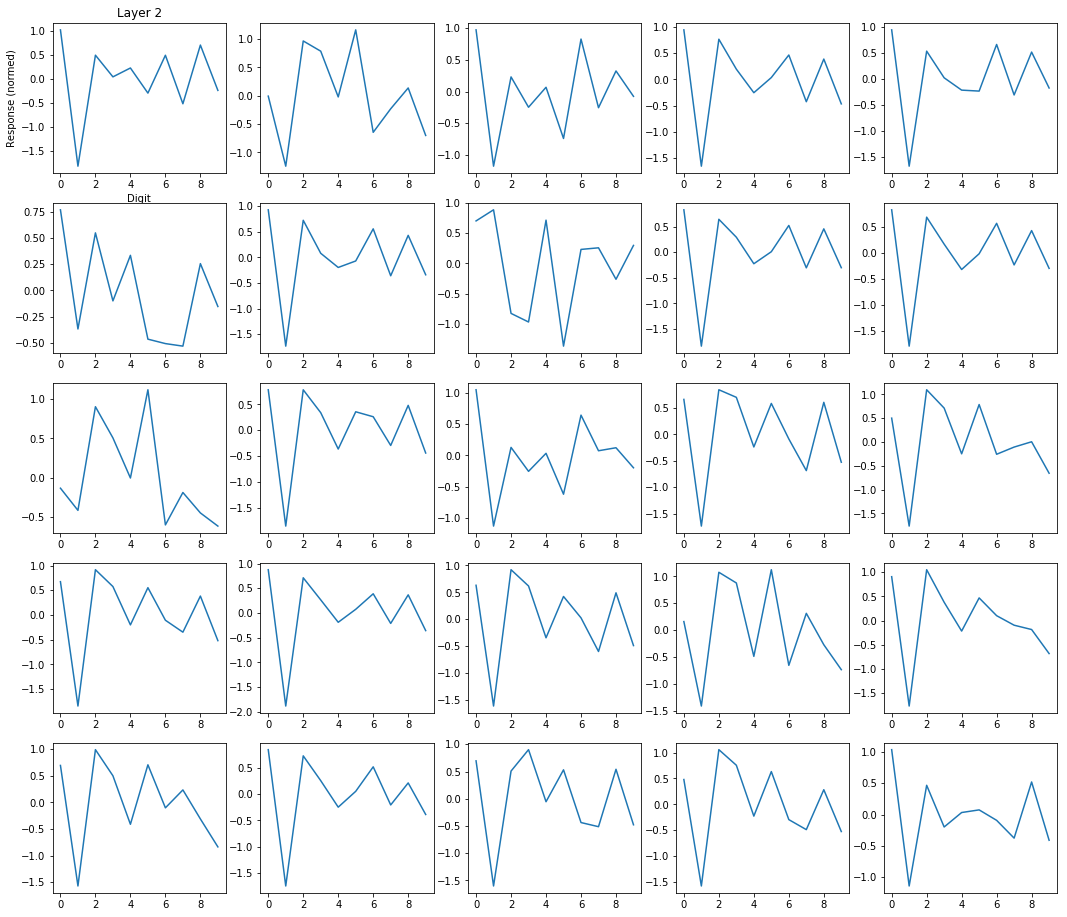

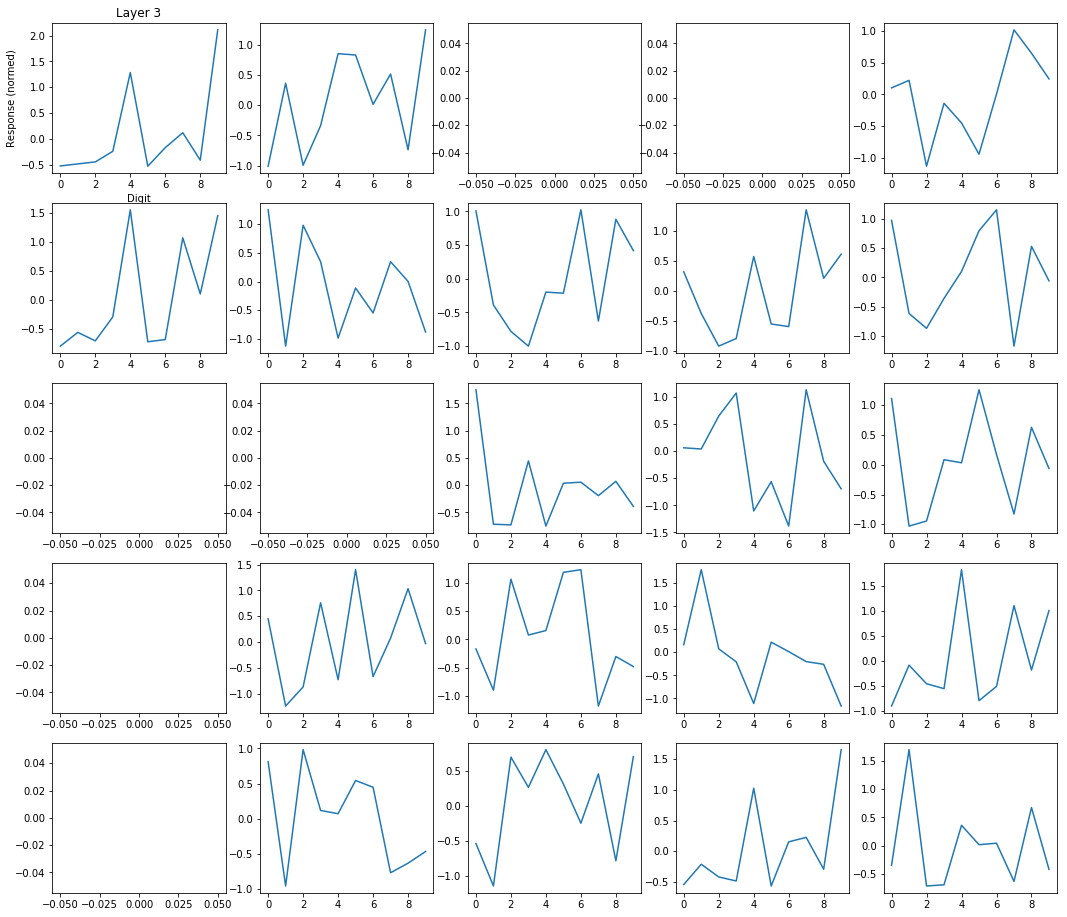

In [0]:
#To know how to apply attention, we need to calculate tuning curves.

def make_TCs(act,labs):
    if len(act.shape) == 4:
       act_means = np.nanmean(act,(1,2))
    else:
       act_means = act

    dig_means = np.zeros((num_classes,act.shape[-1]))
    for d in range(num_classes):
        inds = np.where(labs==d)[0]
        dig_means[d,:] = np.nanmean(act_means[inds,:],0)
    TCs = (dig_means - np.nanmean(act_means,0))/np.nanstd(act_means,0)
    return TCs

#This is how we "record" neural activity in the network
conv1 = tf.get_default_graph().get_tensor_by_name("conv1:0")
conv2 = tf.get_default_graph().get_tensor_by_name("conv2:0")
FC1 = tf.get_default_graph().get_tensor_by_name("fc1:0")

activity = sess.run([conv1,conv2,FC1],feed_dict={x: ims_val, y_int: labs_val, TVals_1: np.ones(FM_1), TVals_2: np.ones(FM_2), TVals_3: np.ones(FM_3), keep_prob: 1.})

#Making tuning curves from this activity:
tuning_curves = []
for act in activity:
    tuning_curves.append(make_TCs(act,labs_val))

#Looking at some of these tuning curves
for L in range(len(tuning_curves)):
  plt.figure(figsize=(18, 16))
  for fm in range(25):
    plt.subplot(5,5,fm+1)
    plt.plot(np.arange(10),tuning_curves[L][:,fm])
    if fm==0:
       plt.title('Layer '+str(L+1))
       #if fm==20:
       plt.xlabel('Digit'); plt.ylabel('Response (normed)'); 
plt.show()

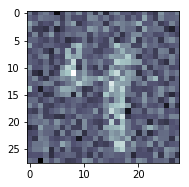

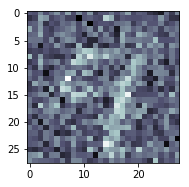

In [0]:
#Now we will run the network with attention. For this we need to make noisy images.
def make_imageset(ims,labs,dig,noise_scl=1.):
    dig_inds = np.where(labs==dig)[0][0:batch_size//2]
    nondig_inds = np.where(labs!=dig)[0][0:batch_size//2]
    inds = np.concatenate([dig_inds,nondig_inds])
    dig_ims = ims[inds,:]
    dig_ims += np.random.randn(dig_ims.shape[0],dig_ims.shape[1])*noise_scl
    return dig_ims

def make_Tvals(TCs, dig):
    #this uses tuning information to determine how to scale the network activity
    Tvals = TCs[dig,:]
    Tvals[np.isnan(Tvals)] = 0
    Tvals += 1
    Tvals[Tvals<0] = 0
    return Tvals



attn_dig = 4 #digit attention is applied to
attn_layer = 2 #layer attention is applied at

#getting noisy test set:
ims_noise = make_imageset(data.val_images[batch_size:,:],data.val_labels[batch_size:],attn_dig,noise_scl=1.5)

#Example of noisy images (first half contain the attended digit, second half do not)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.reshape(ims_noise[0,:],[im_size,im_size]),cmap='bone'); plt.show()
plt.subplot(1,2,2)
plt.imshow(np.reshape(ims_noise[batch_size//2,:],[im_size,im_size]),cmap='bone'); plt.show()



0.0 [7 2 5 4 5 7 2 4 4 4 4 7 2 7 2 4 5 2 2 4 5 2 4 4 2 2 3 4 5 2 8 4 8 2 4 8 8
 2 4 7 4 5 4 8 2 7 4 4 2 4 4 7 5 2 2 2 7 7 4 4 2 4 4 2 7 2 2 2 5 8 2 2 7 2
 1 2 7 7 5 3 3 1 2 8 2 2 2 2 5 2 2 5 5 2 3 0 2 3 5 7 2 5 2 5 5 5 7 5 5 2 2
 5 2 5 3 7 5 5 2 2 3 7 5 2 2 2 2 2]
0.1 [7 2 4 4 7 7 2 4 4 4 4 7 7 7 2 4 5 2 2 4 5 2 4 4 2 2 7 4 2 2 8 4 8 2 4 4 8
 2 4 7 4 5 4 8 2 7 4 4 2 4 4 7 5 2 2 2 7 7 4 4 2 4 4 2 7 2 2 2 5 8 2 2 7 2
 1 2 7 7 5 3 3 1 2 8 2 2 2 2 5 2 2 5 5 2 3 0 2 3 7 7 2 5 2 5 5 2 7 5 5 2 2
 5 2 5 3 7 5 5 2 2 3 7 5 2 2 2 2 2]
0.2 [7 4 4 4 7 7 2 4 4 4 4 7 7 7 2 4 5 2 2 4 5 2 4 4 2 2 7 4 2 2 8 4 8 2 4 4 8
 2 4 7 4 4 4 7 2 7 4 4 2 4 4 4 5 4 2 2 7 7 4 4 2 4 4 2 7 2 2 2 5 8 2 2 7 2
 1 2 7 7 5 7 3 1 2 8 0 2 2 1 5 2 2 5 5 2 3 0 2 3 7 7 2 5 2 5 5 2 7 7 5 2 2
 5 2 5 3 7 5 5 1 2 3 7 5 2 2 2 2 2]
0.30000000000000004 [7 4 4 4 7 4 2 4 4 4 4 7 7 7 2 4 5 4 2 4 5 2 4 4 2 2 7 4 7 2 8 4 4 2 4 4 4
 2 4 7 4 4 4 7 2 7 4 4 2 4 4 4 5 4 2 2 7 7 4 4 4 4 4 2 7 2 2 2 5 8 2 2 7 2
 1 2 7 7 5 7 3 1 2 8 0 2 2 1 5 2 2 

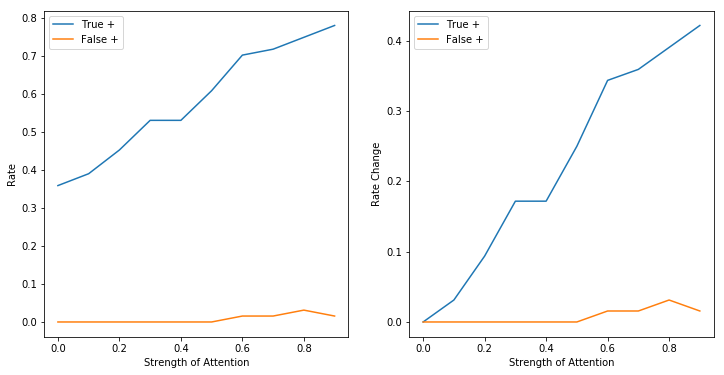

In [0]:
#In this loop, attention is applied with increasing strength, and true and false positive rates are calculated
strngs = np.arange(0,1,.1)
TPs = []; FPs = []
for strng in strngs:
    Tvals = make_Tvals(tuning_curves[attn_layer-1]*strng,attn_dig)
    if attn_layer == 1:
        predictions = preds.eval(feed_dict={x: ims_noise,  TVals_1: Tvals, TVals_2: np.ones(FM_2), TVals_3: np.ones(FM_3), keep_prob: 1.})

    elif attn_layer == 2:
        predictions = preds.eval(feed_dict={x: ims_noise,  TVals_1: np.ones(FM_1), TVals_2: Tvals, TVals_3: np.ones(FM_3), keep_prob: 1.})

    elif attn_layer == 3:
        predictions = preds.eval(feed_dict={x: ims_noise, TVals_1: np.ones(FM_1), TVals_2: np.ones(FM_2), TVals_3: Tvals, keep_prob: 1.})

    TPs.append(np.sum(predictions[0:batch_size//2]==attn_dig)/(len(predictions)//2))
    FPs.append(np.sum(predictions[batch_size//2:]==attn_dig)/(len(predictions)//2))

    print(strng, predictions)

#Results of applying attention on performance: 
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(strngs,TPs)
plt.plot(strngs,FPs)
plt.xlabel('Strength of Attention')
plt.ylabel('Rate')
plt.legend(['True +', 'False +'])
plt.subplot(1,2,2)
plt.plot(strngs,TPs-TPs[0])
plt.plot(strngs,FPs-FPs[0])
plt.xlabel('Strength of Attention')
plt.ylabel('Rate Change')
plt.legend(['True +', 'False +'])

plt.show()